In [1]:
if globals().get('__file__') is None:
    __file__ = '00_pascal_voc.ipynb'

import os
import sys
import pathlib
parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
print('parent_dir: ', parent_dir)
sys.path.append(parent_dir)
# from utils.dirichlet_split import get_dirichlet_distribution

parent_dir:  /home/suncheol/code/FedTest/FedMAD


In [2]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as  models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import sys
# from utils import encode_labels
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import Dataset


/home/suncheol/code/FedTest/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

def encode_labels(target):
    """
    Encode multiple labels using 1/0 encoding 
    Args:
        target: xml tree file
    Returns:
        torch tensor encoding labels as 1/0 vector
    """
    ls = target['annotation']['object']
    j = []
    if type(ls) == dict:
        if int(ls['difficult']) == 0:
            j.append(object_categories.index(ls['name']))
    else:
        for i in range(len(ls)):
            if int(ls[i]['difficult']) == 0:
                j.append(object_categories.index(ls[i]['name']))
    k = np.zeros(len(object_categories))
    k[j] = 1
    return torch.from_numpy(k)

In [4]:
save_path = pathlib.Path.home().joinpath('.data', 'PASCAL_VOC_2012')
if not save_path.exists():
    save_path.mkdir(parents=True)

In [5]:
# resize 224, 224
transform_default = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor()])

train_datasets = datasets.voc.VOCDetection(root='~/.data/', year='2012', image_set='train', download=False, transform = transform_default, target_transform = encode_labels)
val_datasets = datasets.voc.VOCDetection(root='~/.data/', year='2012', image_set='val', download=False, transform = transform_default, target_transform = encode_labels)

train_loader = DataLoader(train_datasets, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_datasets, batch_size=16, shuffle=True, num_workers=4)

train_images = torch.stack([image for image, _ in train_datasets]).numpy()
train_labels = torch.stack([label for _, label in train_datasets]).numpy()

val_images = torch.stack([image for image, _ in val_datasets]).numpy()
val_labels = torch.stack([label for _, label in val_datasets]).numpy()

In [6]:
np.save(save_path.joinpath('train_images.npy'), train_images)
np.save(save_path.joinpath('train_labels.npy'), train_labels)
np.save(save_path.joinpath('val_images.npy'), val_images)
np.save(save_path.joinpath('val_labels.npy'), val_labels)

In [7]:
train_images = np.load(save_path.joinpath('train_images.npy'))
train_labels = np.load(save_path.joinpath('train_labels.npy'))
val_images = np.load(save_path.joinpath('val_images.npy'))
val_labels = np.load(save_path.joinpath('val_labels.npy'))

In [8]:
train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

((5717, 3, 224, 224), (5717, 20), (5823, 3, 224, 224), (5823, 20))

In [9]:
class CustomDataset(Dataset):
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        self.imgs = self._to_tensor(self.imgs)
        self.labels = self._to_tensor(self.labels)
        
    def __len__(self):
        return len(self.imgs)
    
    def _to_tensor(self, img):
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img)
        return img
    
    def _to_pil_image(self, img):  
        if not isinstance(img, Image.Image):
            if img.shape[0] == 3:
                # img = img.transpose(1, 2, 0)
                img = img.permute(1, 2, 0)
            if img.max() <= 1.0:
                img = img*255
            if img.dtype != np.uint8:
                img = np.uint8(img) 
            img = Image.fromarray(img)
        return img

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        
        if self.transform:
            # img = self._to_tensor(img)
            img = self._to_pil_image(img)
            img = self.transform(img)
        return img, label
    
    def save_npz(self, path):
        np.savez(path, imgs=self.imgs, labels=self.labels)
    
    def load_npz(self, path):
        data = np.load(path)
        self.imgs = data['imgs']
        self.labels = data['labels']

# class CustomSegDataset(CustomDataset):
#     def __init__(self, imgs, labels, transform=None):
#         super().__init__(imgs, labels, transform)
    
#     def __getitem__(self, idx):
#         img = self.imgs[idx]
#         label = self.labels[idx]
        
#         if self.transform:
#             img = self._to_pil_image(img)
#             img = self.transform(img)
#         return img, label

transform_train = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_datasets_sub = CustomDataset(train_images, train_labels, transform=transform_train)
train_loader_sub = DataLoader(train_datasets_sub, batch_size=16, shuffle=True, num_workers=4)
train_images_sub = torch.stack([image for image, _ in train_datasets_sub]).numpy()
train_labels_sub = torch.stack([label for _, label in train_datasets_sub]).numpy()

In [10]:
train_images_sub.shape, train_labels_sub.shape

((5717, 3, 224, 224), (5717, 20))

In [11]:
from utils.multi_label_encoding import get_label_to_index, get_index_to_label

val_indices = get_label_to_index(val_labels)
train_indices = get_label_to_index(train_labels)

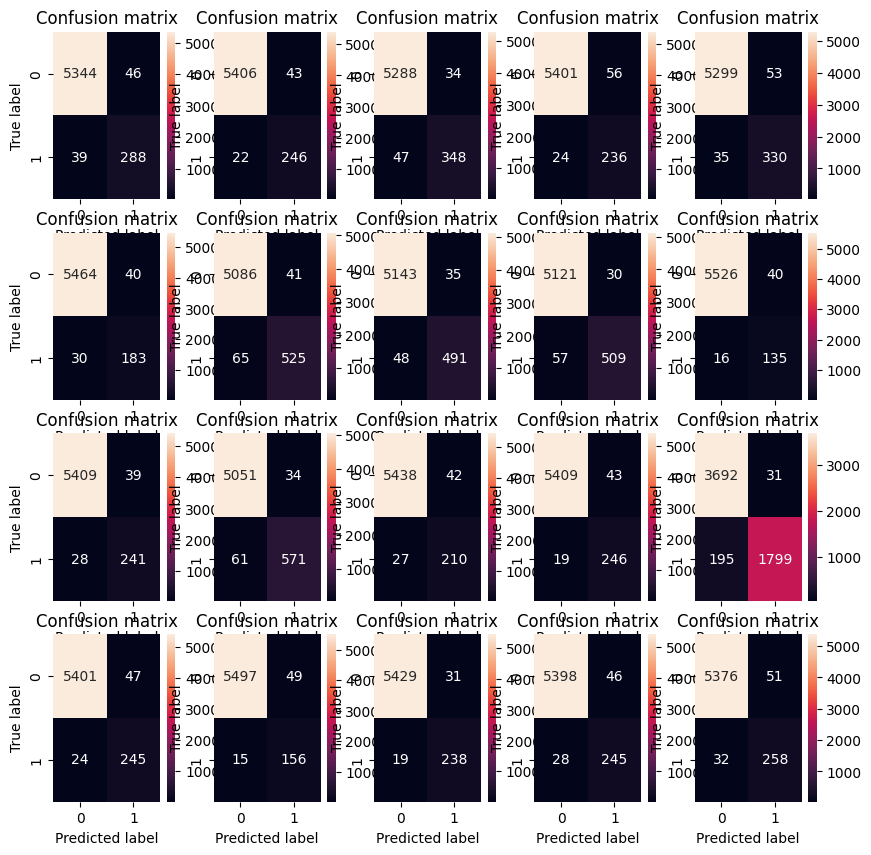

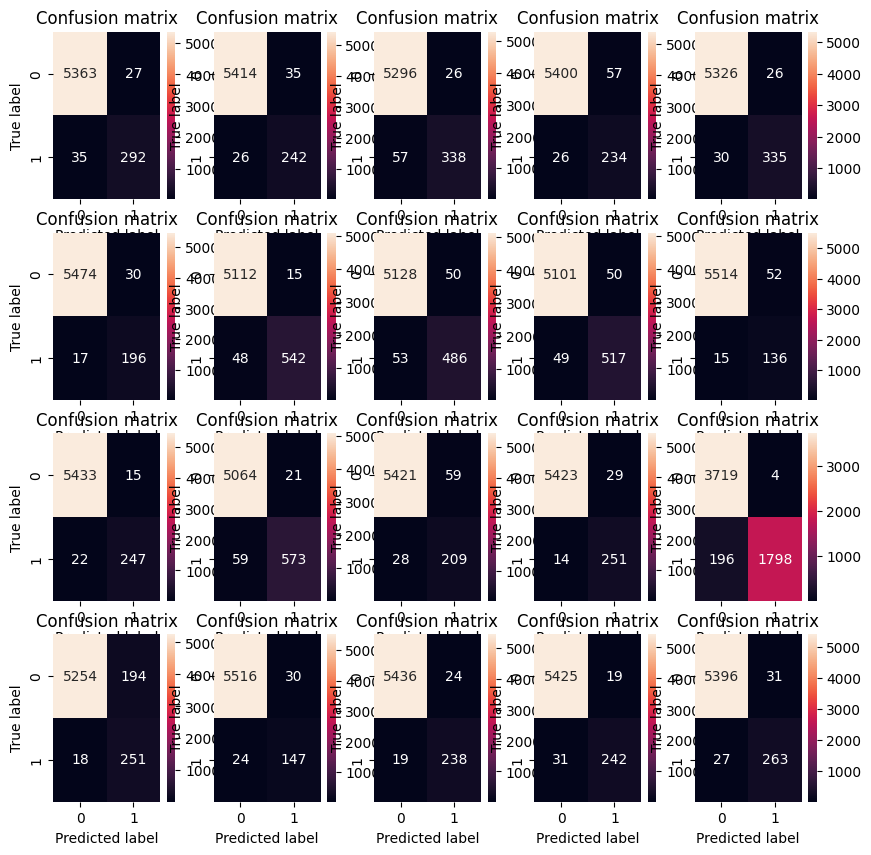

In [72]:
from utils.noisy_label import *

adding_noise = True                                 # adding noise or not
add_noise_type = "symmetric"                        # Noise Type: "symmetric" or "pairflip"
noise_rate = 0.1                                    # Noise Rate

noisy_labels = add_noisy_labels(train_labels, noise_type=add_noise_type, noise_rate=noise_rate)
noisy_labels2 = add_noisy_labels(train_labels, noise_type="pairflip", noise_rate=noise_rate)

draw_confusion_matrix(train_labels, noisy_labels)
draw_confusion_matrix(train_labels, noisy_labels2)

party_id: 0, num of samples: 1057
party_id: 1, num of samples: 1034
party_id: 2, num of samples: 1045
party_id: 3, num of samples: 1043
party_id: 4, num of samples: 1050
Party 0 has 1057 images
Party 1 has 1034 images
Party 2 has 1045 images
Party 3 has 1043 images
Party 4 has 1050 images
n_client: 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n_client: 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n_client: 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n_client: 3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n_client: 4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


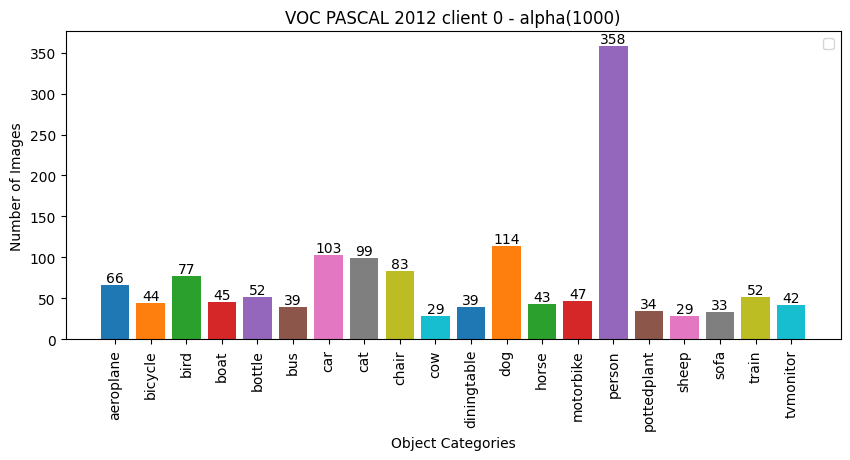

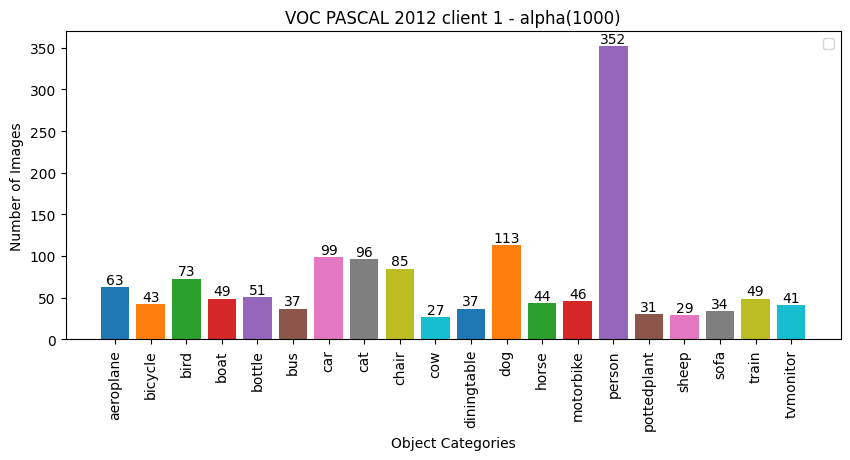

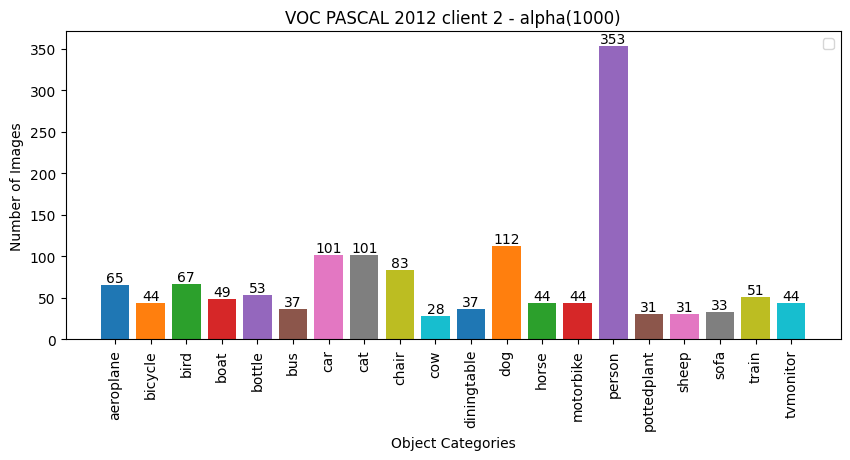

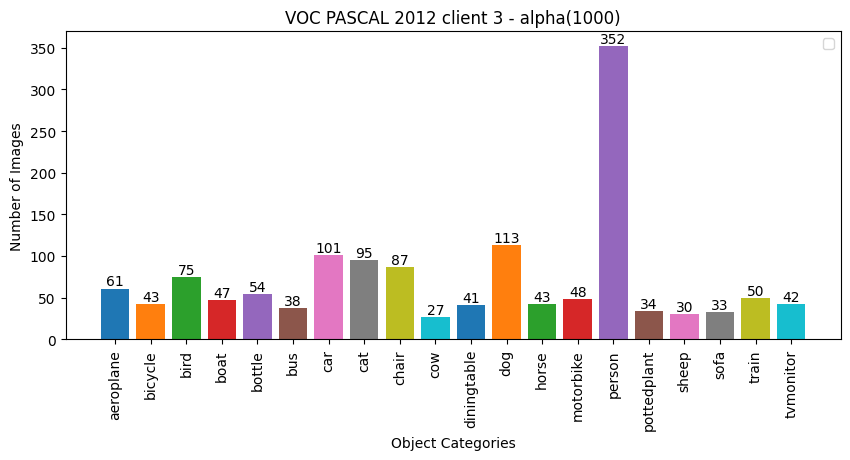

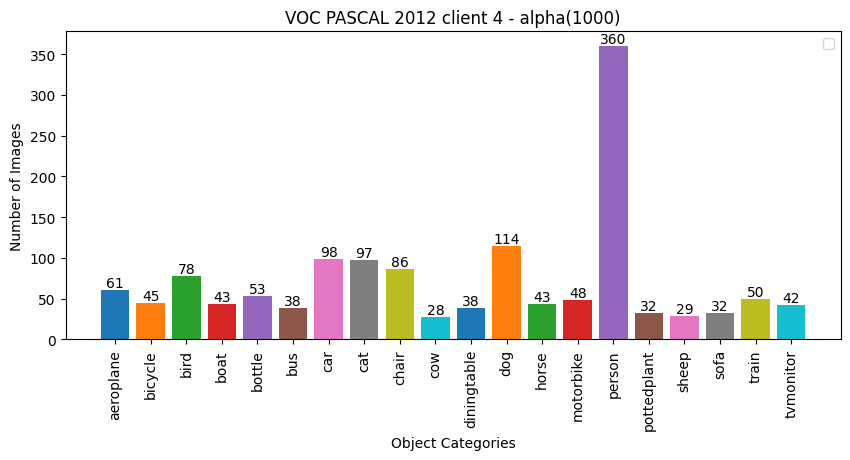

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import utils.dirichlet_split as dirichlet

def get_party_y_data(y, dict_indices_inv):
    y = np.array([dict_indices_inv[i] for i in y])
    return np.array(get_index_to_label(y, 20))

def plot_class_distribution(y_data, object_categories, title="PASCAL VOC 2012"):
    plt.figure(figsize=(10, 4))
    y_total = np.sum(y_data, axis=0)
    for i in range(len(object_categories)):
        plt.bar(object_categories[i], y_total[i])
        plt.text(object_categories[i], y_total[i], y_total[i], ha='center', va='bottom')
    plt.title(title)
    plt.xlabel('Object Categories')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.legend()

# Prepare data
unique, counts = np.unique(train_indices, return_counts=True)

dict_indices = dict(zip(unique, range(len(unique))))
dict_indices_inv = dict(zip(range(len(unique)), unique))
X_train = train_images
y_train = np.array([dict_indices[i] for i in train_indices])
# y_val = np.array([dict_indices[i] for i in val_indices])

N_class = len(unique)
N_parties = 5
alpha = 1000

dirichlet_arr = dirichlet.get_dirichlet_distribution_count(N_class, N_parties, y_train, alpha)
dirichlet.set_random_seed(0)
# dirichlet.plot_dirichlet_distribution(N_class, N_parties, alpha)
# dirichlet.plot_dirichlet_distribution_count(N_class, N_parties, y_train, alpha)
# whole_y = np.hstack((y_train, y_val))
# dirichlet.plot_whole_y_distribution(whole_y)
# dirichlet.plot_dirichlet_distribution_count_subplot(N_class, N_parties, y_train, alpha)

split_dirichlet_data = dirichlet.get_dirichlet_split_data(X_train, y_train, N_parties, N_class, alpha)
dirichlet_path = save_path.joinpath(f'N_clients_{N_parties}_alpha_{alpha}_noise_{add_noise_type}_{noise_rate}')
dirichlet_path.mkdir(parents=True, exist_ok=True)

for i in range(N_parties):
    np.save(dirichlet_path.joinpath(f'Party_{i}_X_data.npy'), split_dirichlet_data[i]['x'])
    y_party = get_party_y_data(split_dirichlet_data[i]['y'], dict_indices_inv)
    y_party_noisy = add_noisy_labels(y_party, noise_type=add_noise_type, noise_rate=noise_rate)
    np.save(dirichlet_path.joinpath(f'Party_{i}_y_data.npy'), y_party)
    np.save(dirichlet_path.joinpath(f'Party_{i}_y_data_noisy.npy'), y_party_noisy)
    print(f'Party {i} has {len(y_party)} images')

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

for n_client in range(N_parties):
    print(f'n_client: {n_client}')
    dirichlet_path = save_path.joinpath(f'N_clients_{N_parties}_alpha_{alpha}_noise_{add_noise_type}_{noise_rate}')
    if not dirichlet_path.exists():
        dirichlet_path.mkdir(parents=True, exist_ok=True)
    X_train_party = np.load(dirichlet_path.joinpath(f'Party_{n_client}_X_data.npy'))
    y_train_party = np.load(dirichlet_path.joinpath(f'Party_{n_client}_y_data.npy'))
    plot_class_distribution(y_train_party, object_categories, title=f'VOC PASCAL 2012 client {n_client} - alpha({alpha})')
    # # Save figure
    # plt.savefig(dirichlet_path.joinpath(f'Party_{n_client}_y_data.png'))
    # plt.show()

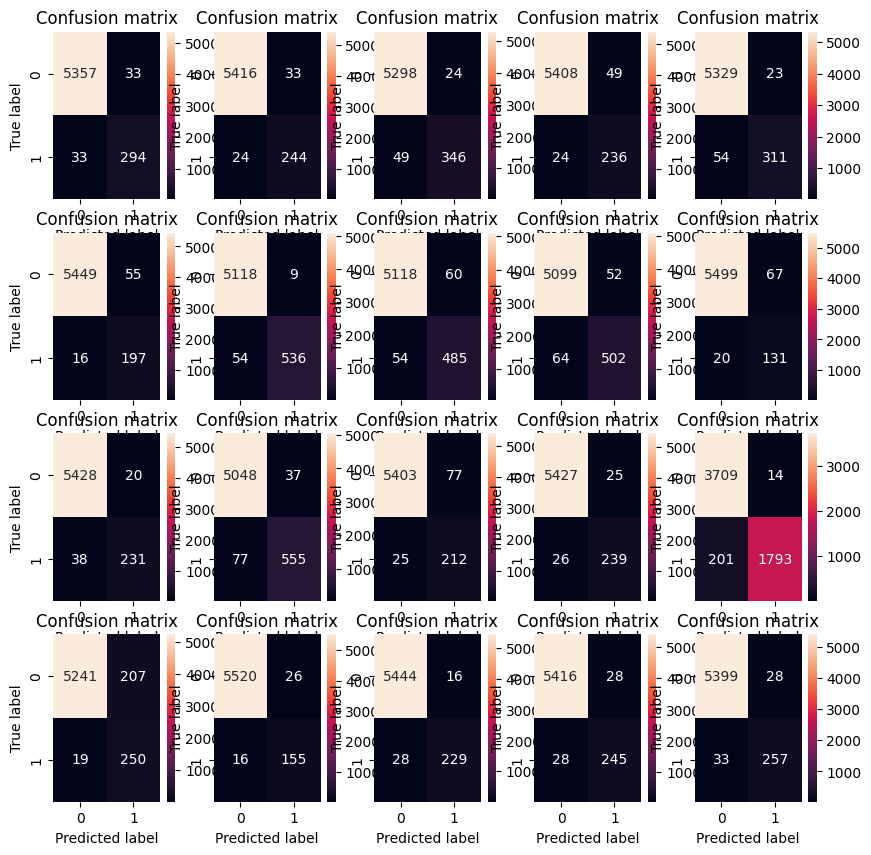

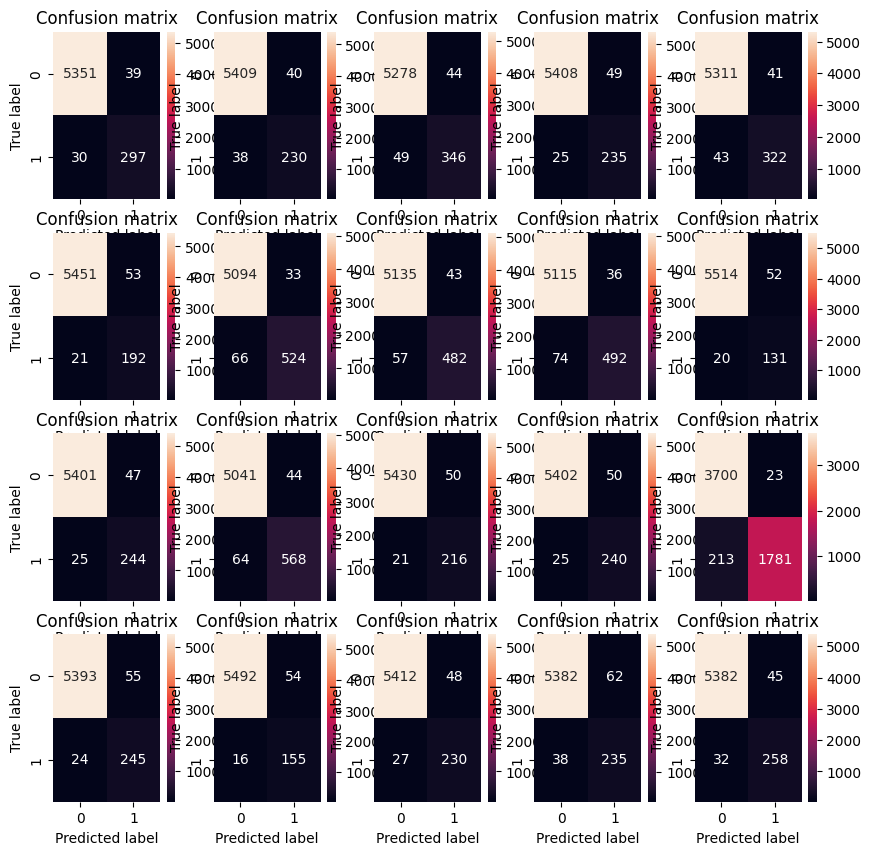

In [22]:
# from utils.sampling import iid_sampling, non_iid_dirichlet_sampling

# train_indices_sub = iid_sampling(100, 10, seed=0)

In [23]:
# test = non_iid_dirichlet_sampling(train_labels, 20, 0.5, 5, seed=0)

In [24]:
# def add_noise(args, y_train, dict_users):
#     np.random.seed(args.seed)

#     gamma_s = np.random.binomial(1, args.level_n_system, args.num_users)
#     gamma_c_initial = np.random.rand(args.num_users)
#     gamma_c_initial = (1 - args.level_n_lowerb) * gamma_c_initial + args.level_n_lowerb
#     gamma_c = gamma_s * gamma_c_initial

#     y_train_noisy = copy.deepcopy(y_train)

#     real_noise_level = np.zeros(args.num_users)
#     for i in np.where(gamma_c > 0)[0]:
#         sample_idx = np.array(list(dict_users[i]))
#         prob = np.random.rand(len(sample_idx))
#         noisy_idx = np.where(prob <= gamma_c[i])[0]
#         y_train_noisy[sample_idx[noisy_idx]] = np.random.randint(0, 10, len(noisy_idx))
#         noise_ratio = np.mean(y_train[sample_idx] != y_train_noisy[sample_idx])
#         print("Client %d, noise level: %.4f (%.4f), real noise ratio: %.4f" % (
#             i, gamma_c[i], gamma_c[i] * 0.9, noise_ratio))
#         real_noise_level[i] = noise_ratio
#     return (y_train_noisy, gamma_s, real_noise_level)


party_id: 0, num of samples: 809
party_id: 1, num of samples: 1011
party_id: 2, num of samples: 1132
party_id: 3, num of samples: 1162
party_id: 4, num of samples: 1165
Party 0 has 809 images
Party 1 has 1011 images
Party 2 has 1132 images
Party 3 has 1162 images
Party 4 has 1165 images
n_client: 0
n_client: 1
n_client: 2
n_client: 3
n_client: 4


In [ ]:
def noisy_labels(y, noise_rate):
    y_noisy = np.copy(y)
    for i in range(len(y)):
        if np.random.rand() < noise_rate:
            y_noisy[i] = np.random.randint(0, 20)
    return y_noisy

In [ ]:
def IID_split(X, y, n_clients):
    n_samples = len(X)
    n_samples_per_client = n_samples // n_clients
    X_split = []
    y_split = []
    for i in range(n_clients):
        X_split.append(X[i * n_samples_per_client: (i + 1) * n_samples_per_client])
        y_split.append(y[i * n_samples_per_client: (i + 1) * n_samples_per_client])
    return X_split, y_split

In [82]:
from utils.dirichlet_split import *
set_random_seed(0)

train_images = np.load(save_path.joinpath('train_images.npy'))
train_labels = np.load(save_path.joinpath('train_labels.npy'))
split_dirchlet_data_dict = get_dirichlet_split_data(train_images, train_labels, N_parties=10, N_class=20)

ValueError: object too deep for desired array

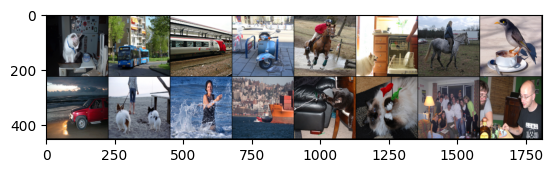

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

# image grid
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader2)
images, labels = dataiter.next()
 
# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
def get_img_label(dataset):
    imgs = []
    labels = [] 
    for i, (img, label) in enumerate(dataset):
        img, label = img.cpu().numpy(), label.cpu().numpy()
        imgs.append(img)
        labels.append(label)
    imgs = np.array(imgs)
    labels = np.array(labels)
    return imgs, labels

train_imgs, train_labels = get_img_label(train_datasets)
val_imgs, val_labels = get_img_label(val_datasets)

In [ ]:
# PASCAL VOC 2012
path = pathlib.Path('../data/PASCAL_VOC_2012/')
path.mkdir(parents=True, exist_ok=True)
np.save(path.joinpath('PASCAL_VOC_train_224_Img.npy'), train_imgs)
np.save(path.joinpath('PASCAL_VOC_train_224_Label.npy'), train_labels)
np.save(path.joinpath('PASCAL_VOC_val_224_Img.npy'), val_imgs)
np.save(path.joinpath('PASCAL_VOC_val_224_Label.npy'), val_labels)

In [5]:
import sys 
sys.path.append("..")
import utils.utils as utils
import utils.dirichlet_split as dirichlet

In [22]:
import pathlib
# path = pathlib.Path('~/.data/PASCAL_VOC_2012/')
path = pathlib.Path.home().joinpath('.data/PASCAL_VOC_2012/')
val_imgs = np.load(path.joinpath('PASCAL_VOC_val_224_Img.npy'))
val_labels = np.load(path.joinpath('PASCAL_VOC_val_224_Label.npy'))
train_imgs = np.load(path.joinpath('PASCAL_VOC_train_224_Img.npy'))
train_labels = np.load(path.joinpath('PASCAL_VOC_train_224_Label.npy'))
val_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [25]:
len(val_labels), sum(sum(val_labels))

(5823, 8351.0)

In [ ]:
# invert onehotvector (labels to index for multi labels)
'''
[0,0,0,0,0,0] = 0
[1,0,0,0,0,0] = 1
[0,1,0,0,0,0] = 2
[0,1,1,0,0,0] = 6

'''
def get_oct_num(list):
    oct_num = 0
    for i in range(len(list)):
        oct_num += list[i] * 2 ** i
    return oct_num

def get_bin_num(oct, nClass):
    bin_num = []
    for i in range(nClass):
        bin_num.append(oct % 2)
        oct = oct // 2
    return bin_num
     
def get_label_to_index(labels):
    label_index = []
    for i in range(len(labels)):
        o = get_oct_num(labels[i])
        label_index.append(o)
    return label_index

def get_index_to_label(label_index, nClass):
    label_onehot = []
    for i in range(len(label_index)):
        label_onehot.append(get_bin_num(label_index[i], nClass))
    return label_onehot

val_indices = get_label_to_index(val_labels)
train_indices = get_label_to_index(train_labels)

In [10]:
y_total = np.sum(val_labels, axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


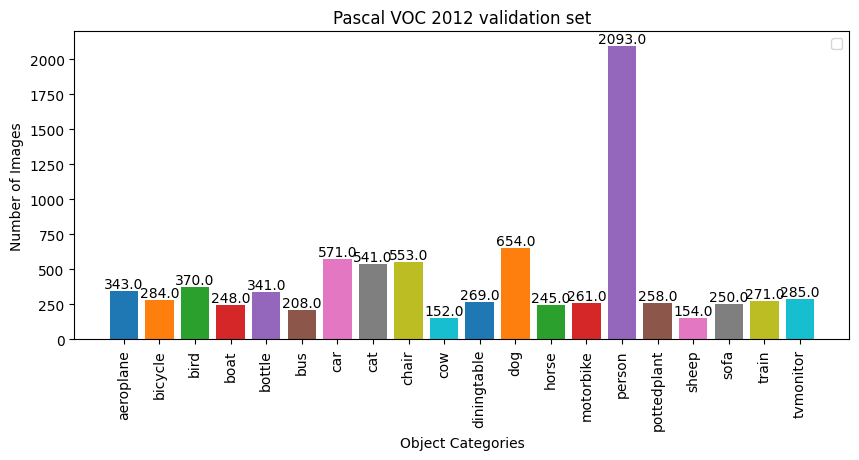

In [29]:
%matplotlib inline
# plot classes distritubtion
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(10, 4))
for i in range(len(object_categories)):
    # not overlapped text 
    plt.bar(object_categories[i], y_total[i])
    plt.text(object_categories[i], y_total[i], y_total[i], ha='center', va='bottom') 
plt.title(f'Pascal VOC 2012 validation set')
plt.xlabel('Object Categories')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.legend()
plt.savefig('Pascal VOC 2012 validation set.png')
plt.show()


In [ ]:
unique, counts = np.unique(train_indices, return_counts=True)
dict_indices = dict(zip(unique, range(len(unique))))
dict_indices_inv = dict(zip(range(len(unique)), unique))
X_train = train_imgs
y_train = np.array([dict_indices[i] for i in train_indices])

N_class = len(unique)
N_parties = 5
alpha = 1

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(img, gt, test_size=0.2, random_state=42, stratify=gt)

dirchlet_arr = dirichlet.get_dirichlet_distribution_count(N_class, N_parties, y_train, alpha)
# np.random.RandomState(1)
dirichlet.set_random_seed(0)
dirichlet.plot_dirichlet_distribution(N_class, N_parties, alpha)
dirichlet.plot_dirichlet_distribution_count(N_class, N_parties, y_train, alpha)
whole_y = np.hstack((y_train, y_test))
dirichlet.plot_whole_y_distribution(whole_y)
dirichlet.plot_dirichlet_distribution_count_subplot(N_class, N_parties, y_train, alpha)
split_dirchlet_data = dirichlet.get_dirichlet_split_data(X_train, y_train, N_parties, N_class, alpha)
y = split_dirchlet_data[0]['y']
y = np.array([dict_indices_inv[i] for i in y])
y = np.array(get_index_to_label(y, 20))
y.shape
# dirichlet_path
dirichlet_path = pathlib.Path(f'./../data/PASCAL_VOC_2012/dirichlet/alpha_{alpha}/')
dirichlet_path.mkdir(parents=True, exist_ok=True)

for i in range(N_parties):
    np.save(dirichlet_path.joinpath(f'Party_{i}_X_data.npy'), split_dirchlet_data[i]['x'])
    y = split_dirchlet_data[i]['y']
    y = np.array([dict_indices_inv[i] for i in y])
    y = np.array(get_index_to_label(y, 20))
    np.save(dirichlet_path.joinpath(f'Party_{i}_y_data.npy'), y)
    
# plot classes distritubtion
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

# load numpy data
for n_client in range(N_parties):
    print(f'n_client: {n_client}')
    plt.figure(figsize=(10, 4))
    dirichlet_path = pathlib.Path(f'./../data/PASCAL_VOC_2012/dirichlet/alpha_{alpha}/')
    X_train_0 = np.load(dirichlet_path.joinpath(f'Party_{n_client}_X_data.npy'))
    y_train_0 = np.load(dirichlet_path.joinpath(f'Party_{n_client}_y_data.npy'))
    y_total = np.sum(y_train_0, axis=0)
    for i in range(len(object_categories)):
        # not overlapped text 
        plt.bar(object_categories[i], y_total[i])
        plt.text(object_categories[i], y_total[i], y_total[i], ha='center', va='bottom') 
    plt.title(f'PASCAL VOC 2012 (party {n_client}), alpha={alpha}')
    plt.xlabel('Object Categories')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.legend()

    # save figure 
    save_path = pathlib.Path(f"../figures/dirichlet/alpha_{alpha}/")
    save_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path.joinpath(f'Party_{n_client}_y_data.png'))
    plt.show()